In [1]:
%run imports.ipynb

In [2]:
FT_MODELS_PATH="/home/dora/Desktop/recommender/datasets/master_generated/6-10-200000-100_ID@_6/MODELS/128_0.001@0623-012052"
tf_user_tower=glob.glob(FT_MODELS_PATH+'/*userTower*')[0]
ft_user_tower= tf.keras.models.load_model(tf_user_tower,compile=False)
ft_article_tower= ft_user_tower

SB_MODELS_PATH="/home/dora/Desktop/recommender/datasets/master_generated/6-10-200000-100_ID@_6/MODELS/128_0.001@0628-160032"
sb_user_tower=glob.glob(SB_MODELS_PATH+'/*sharedTower*')[0]
sb_user_tower= tf.keras.models.load_model(sb_user_tower,compile=False)
sb_article_tower= sb_user_tower

In [145]:
SAVE_PATH = "/home/dora/osci-syn/nemojbrisat_maknuticu/slike/grafovi/" 

In [3]:
pos_neg_df=pd.read_csv("/home/dora/Desktop/recommender/datasets/twitter/user_pos_neg_ids_27_3.csv")

In [4]:
pos_neg_df.head(2)

,Unnamed: 0,userID,posIDs,outIDs,negIDs
0,0,4910170583,"{'S1359645422001896', 'S1359645422001471', 'S1...","['S2589152922000485', 'S2589152922000679', 'S2...","['53e99fc2b7602d9702899dc1', '5736956d6e3b1202..."
1,1,973267080781942785,"{'S003238611730664X', 'S0167779913002072', 'S0...","['S0032386117306390', 'S0001868608001401', 'S0...","['53e9a3c0b7602d9702cd0244', '5de0e5b2df1a9c0c..."


### ids_lab_df dataset

### Twitter:
### users vectors

In [5]:
try:
    ids_lab_df
except:
    ids_lab_df=pd.read_parquet("/home/dora/Desktop/recommender/datasets/tw_0604_ids.parquet")

In [6]:
try :
    users_vect_df
except:
    users_vect_df=pd.read_parquet("/home/dora/Desktop/recommender/datasets/tw_0604_user_vectors.parquet")

In [7]:
#users_vect_df.head(1)

In [8]:
try:
    user_vect_dict_ft
except:
    user_vect_dict_ft =pd.read_parquet("/home/dora/Desktop/recommender/datasets/tw_0604_user_vectors.parquet",  engine='pyarrow').set_index('userID').T.to_dict('list') 
    user_vect_dict_ft = {key: value[0].reshape((1,-1)) for key, value in user_vect_dict_ft.items()} # "unpack" vectors
try:
    user_vect_dict_tr
except:
    user_vect_dict_tr =pd.read_parquet("/home/dora/Desktop/recommender/datasets/tw_0604_user_vectors.parquet",  engine='pyarrow').set_index('userID').T.to_dict('list') 
    user_vect_dict_tr = {key: value[1].reshape((1,-1)) for key, value in user_vect_dict_tr.items()} # "unpack" vectors

## articles vectors

In [9]:
try:
    sia_vect_dict_ft
except:     
    sia_vect_dict_ft =pd.read_parquet("/home/dora/Desktop/recommender/datasets/twitter/sia_vct.parquet",  engine='pyarrow').set_index('artID').T.to_dict('list') 
    sia_vect_dict_ft = {key: value[3].reshape((1,-1)) for key, value in sia_vect_dict_ft.items()} # "unpack" vectors
try:
    sia_vect_dict_tr
except:
    sia_vect_dict_tr =pd.read_parquet("/home/dora/Desktop/recommender/datasets/twitter/sia_vct.parquet",  engine='pyarrow').set_index('artID').T.to_dict('list') 
    sia_vect_dict_tr = {key: value[2].reshape((1,-1)) for key, value in sia_vect_dict_tr.items()} # "unpack" vectors

### dblp - Fasttext

In [10]:
try:
        article_vect_dict_ft
except:
        article_vect_dict_ft =pd.read_parquet('/home/dora/Desktop/recommender/datasets/dblpv13_fasttext.parquet',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict_ft = {key: np.vstack(value) for key, value in article_vect_dict_ft.items()} # "unpack" vectors

### dblp -  transformer

In [11]:
 #SenBert transformer
try:
    article_vect_dict_tr
except:
    article_vect_dict_tr_part1 =pd.read_parquet('/home/dora/Desktop/recommender/datasets/mLM_part_1',  engine='pyarrow').set_index('id').T.to_dict('list') 
    article_vect_dict_tr_part1 = {key: np.vstack(value) for key, value in article_vect_dict_tr_part1.items()} # "unpack" vectors
    article_vect_dict_tr_part2 =pd.read_parquet('/home/dora/Desktop/recommender/datasets/mLM_part_2',  engine='pyarrow').set_index('id').T.to_dict('list') 
    article_vect_dict_tr_part2 = {key: np.vstack(value) for key, value in article_vect_dict_tr_part2.items()} # "unpack" vectors
    article_vect_dict_tr = {**article_vect_dict_tr_part1, **article_vect_dict_tr_part2}

In [12]:
#MERGING TWO DATASETS OF ARTICLE VECTORS  
article_vect_dict_tr={**sia_vect_dict_tr, **article_vect_dict_tr} 
article_vect_dict_ft={**sia_vect_dict_ft, **article_vect_dict_ft} 


In [13]:
not_in_set=list()
for a in set(ids_lab_df['artID']):
    if a not in article_vect_dict_tr.keys():
        not_in_set.append(a)

In [14]:
len(not_in_set), len(set(ids_lab_df['artID']))

(155, 395767)

In [15]:
index_remove = []

for i,row in ids_lab_df.iterrows():
    if row.artID in not_in_set:
        index_remove.append(i) 

In [16]:
ids_lab_df.drop(index_remove, inplace = True)


In [17]:
ids_lab_df=ids_lab_df.reset_index(drop=True)

In [18]:
not_in_set= []

for u in set(ids_lab_df['userID']):
    if u not in set(users_vect_df['userID']): #nije imao dovoljno članaka pa je u nekom trenutku maknut
        not_in_set.append(u)


In [19]:
index_remove = []

for i,row in ids_lab_df.iterrows():
    if row.userID in not_in_set:
        index_remove.append(i) 

In [20]:
ids_lab_df.drop(index_remove, inplace = True)
ids_lab_df=ids_lab_df.reset_index(drop=True)

In [21]:
user_vect_dict_tr=user_vect_dict_tr
user_vect_dict_ft=user_vect_dict_ft


In [22]:
#embedding korisnika
unique_users=set(ids_lab_df['userID'])

embedded_user_tr=dict()
embedded_user_ft=dict()
for u in unique_users:
    embedded_user_ft[u]=ft_user_tower.predict(user_vect_dict_ft[u])[0]
    embedded_user_tr[u]=sb_user_tower.predict(user_vect_dict_tr[u])[0]


In [23]:
#embedding članaka
unique_articles=list(set(ids_lab_df['artID']))

baseline_vectors_tr=np.array([article_vect_dict_tr[a][0] for a in unique_articles])
baseline_vectors_ft=np.array([article_vect_dict_ft[a][0] for a in unique_articles])



embedded_articles_tr=sb_article_tower.predict(baseline_vectors_tr)
embedded_articles_ft=ft_article_tower.predict(baseline_vectors_ft)

In [24]:
embedded_art_ft=dict()
embedded_art_tr=dict()


i=0
for v in embedded_articles_ft:
    embedded_art_ft[unique_articles[i]]=v
    i+=1
    
i=0
for v in embedded_articles_tr:
    embedded_art_tr[unique_articles[i]]=v
    i+=1
    

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

def cos_compare(user_vect,art_vect):
    return cosine_similarity([user_vect],[art_vect])[0,0]

In [26]:
def cos_compare_model_baseline(embedded_user, embedded_art, user_vect_dict, article_vect_dict ):
    cosine_model=[]
    cosine_pure = []
    #pbar = tq.tqdm(total=len(ids_lab_df))
    for i,row in ids_lab_df.iterrows():
        #prvo sličnost modela
        cosine_model.append(cos_compare(embedded_user[row.userID],embedded_art[row.artID]))
        #zatim, sličnost bez naše metode
        cosine_pure.append(cos_compare(user_vect_dict[row.userID][0],article_vect_dict[row.artID][0]))

        #pbar.update(1)
    #pbar.close()
    return cosine_model, cosine_pure

In [27]:
cosine_model_tr=[]
cosine_pure_tr=[]

cosine_model_ft=[]
cosine_pure_ft=[]


In [28]:
import tqdm as tq
from tqdm import tqdm

In [30]:
cosine_model_tr, cosine_pure_tr = cos_compare_model_baseline(embedded_user_tr, embedded_art_tr, user_vect_dict_tr, article_vect_dict_tr)


In [33]:
cosine_model_ft, cosine_pure_ft = cos_compare_model_baseline(embedded_user_ft, embedded_art_ft, user_vect_dict_ft, article_vect_dict_ft)

In [34]:
ids_lab_df_tr=ids_lab_df.copy()
ids_lab_df_ft=ids_lab_df.copy()

ids_lab_df_tr['pure_cosine']=cosine_pure_tr
ids_lab_df_tr['model_cosine']=cosine_model_tr

ids_lab_df_ft['pure_cosine']=cosine_pure_ft
ids_lab_df_ft['model_cosine']=cosine_model_ft

In [36]:
ids_lab_df_ft.head(3)

,userID,artID,label,pure_cosine,model_cosine
0,4910170583,S1359646222001464,1.0,0.871229,0.909358
1,4910170583,S2589152922000783,1.0,0.900254,0.901414
2,4910170583,S1359646222001385,1.0,0.797351,0.823986


### za svakog korisnika sortiraj po kosinusnoj sličnosti, prvo po pure_cosine a zatim po model_cosine

In [37]:
#nepotrebno 
grouped_ft=ids_lab_df_ft.groupby(['userID','label']).agg(model_cos_mean=('model_cosine', 'mean'),
                                                         model_cod_median=('model_cosine', 'median'),
                                                         pure_cos_sim_mean=('pure_cosine', 'mean'),
                                                         pure_cos_sim_median=('pure_cosine', 'median')
                                                        )

In [38]:
#grouped.head()

In [40]:
neg_model_ft=[]
pos_model_ft=[]

neg_pure_ft=[]
pos_pure_ft=[]

for i,row in grouped_ft.iterrows():
    if i[1]==1:
        pos_model_ft.append(row.model_cos_mean)
        pos_pure_ft.append(row.pure_cos_sim_mean)
    elif i[1]==0:
        neg_model_ft.append(row.model_cos_mean)
        neg_pure_ft.append(row.pure_cos_sim_mean)


In [41]:
print("avg user cossim median for positive example [MODEL]: ",np.mean(pos_model_ft))
print("avg user cossim median for positive example: ",np.mean(pos_pure_ft))
print("avg user cossim median for negative example [MODEL]: ",np.mean(neg_model_ft))
print("avg user cossim median for negative example: ",np.mean(neg_pure_ft))

avg user cossim median for positive example [MODEL]:  0.8050608
avg user cossim median for positive example:  0.8464518
avg user cossim median for negative example [MODEL]:  0.46507102
avg user cossim median for negative example:  0.72791606


## kako je rangirano...

In [170]:
def ranked(ids_lab_df):
    user_ranks_m=[]
    user_ranks_p=[]
    for u in unique_users:
        sub_df=ids_lab_df.loc[ids_lab_df['userID']==u]
        sub_df_m=sub_df.sort_values(by=['model_cosine'],ascending=False).reset_index(drop=True)
        #nabavi indekse pozitivnih
        #prvo od modela
        ranks=list(sub_df_m.loc[sub_df_m['label']==1.0].index)
        user_ranks_m.append(ranks)
        #zatim od cistog fasttexta
        sub_df_p=sub_df.sort_values(by=['pure_cosine'],ascending=False).reset_index(drop=True)
        ranks=list(sub_df_p.loc[sub_df_p['label']==1.0].index)
        user_ranks_p.append(ranks)
    return user_ranks_m,user_ranks_p

In [171]:
user_ranks_m_ft, user_ranks_p_ft= ranked(ids_lab_df_ft)


In [172]:
user_ranks_m_tr, user_ranks_p_tr=ranked(ids_lab_df_tr)

## ACC

## modificirani P@k

### Fasttext

In [283]:
MAX_K = 11

In [284]:
lengs= [len(x) for x in user_ranks_p_ft]

In [285]:
np.median(lengs), np.mean(lengs)

(5.0, 11.90379746835443)

In [286]:
all_pk_m_ft,all_pk_p_ft=[],[]
for k in range(1,MAX_K):
    users_res=[]
    for ur in user_ranks_m_ft:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)])) 


    #print("P@k; k=",k)
    #print("model-mean for all users:", np.mean(users_res) )
    all_pk_m_ft.append(np.mean(users_res))

    users_res=[]
    for ur in user_ranks_p_ft:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)]))
    #print("non-model-mean for all users:", np.mean(users_res) )
    all_pk_p_ft.append(np.mean(users_res))

In [287]:
VERSION = "_ft1_"

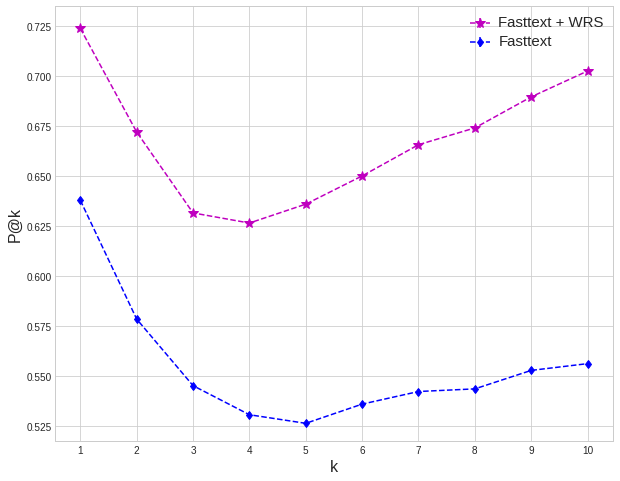

In [288]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure

fig = plt.figure(figsize=(10,8))
#model val
y_m = all_pk_m_ft
#non-model val
y_p = all_pk_p_ft

x=list(range(1,MAX_K))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext + WRS', c='m', marker="*",ms=11, ls = "--")

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",ls = "--",lolims=False,
             label="Fasttext",c='b')
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([min(y_p)-0.009, max(y_m)+0.011])

plt.xlabel('k', fontsize=16)
plt.ylabel('P@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'Pk'+VERSION+'.png',dpi=300)
plt.show()


## P@k SBERT

In [289]:
MAX_K = 11

In [290]:
all_pk_m_tr,all_pk_p_tr=[],[]
for k in range(1,MAX_K):
    users_res=[]
    for ur in user_ranks_m_tr:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)])) 


    #print("P@k; k=",k)
    #print("model-mean for all users:", np.mean(users_res) )
    all_pk_m_tr.append(np.mean(users_res))

    users_res=[]
    for ur in user_ranks_p_tr:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)]))
    #print("non-model-mean for all users:", np.mean(users_res) )
    all_pk_p_tr.append(np.mean(users_res))

In [224]:
VERSION = "_sb1_"

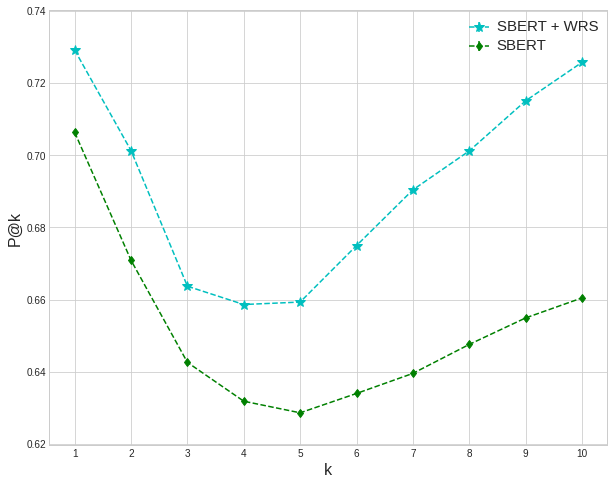

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure

fig = plt.figure(figsize=(10,8))
#model val
y_m = all_pk_m_tr
#non-model val
y_p = all_pk_p_tr

x=list(range(1,MAX_K))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='SBERT + WRS', c='c', marker="*",ms=11, ls = "--")

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",ls = "--",c="g",lolims=False,
             label="SBERT")
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([min(y_p)-0.009, max(y_m)+0.011])

plt.xlabel('k', fontsize=16)
plt.ylabel('P@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'Pk'+VERSION+'.png',dpi=300)
plt.show()


In [226]:
VERSION="_fw_b1_"

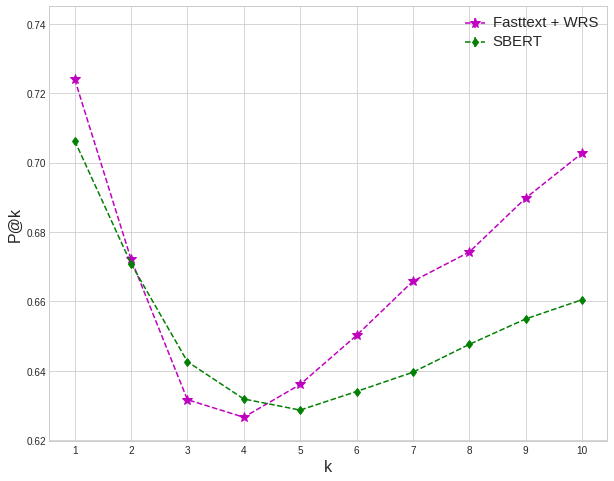

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure

fig = plt.figure(figsize=(10,8))
#model val
y_m = all_pk_m_ft
#non-model val
y_p = all_pk_p_tr

x=list(range(1,MAX_K))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext + WRS', c='m', marker="*",ms=11, ls = "--")

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",c="g",ls = "--",lolims=False,
             label="SBERT")
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([min(y_p)-0.009, max(y_m)+0.021])

plt.xlabel('k', fontsize=16)
plt.ylabel('P@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'Pk'+VERSION+'.png',dpi=300)
plt.show()


In [343]:
VERSION="_fs_"

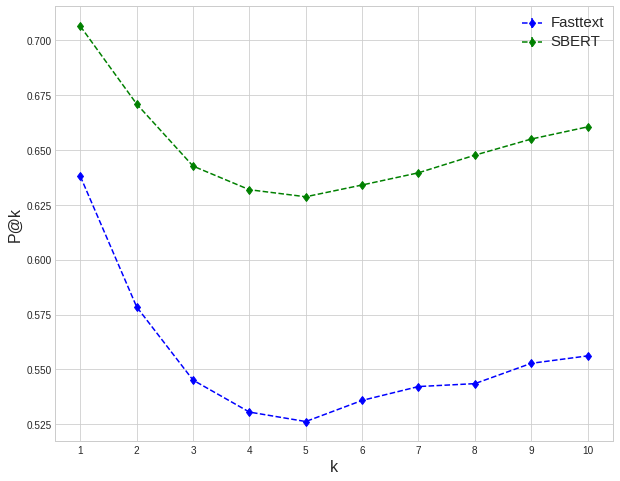

In [344]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure

fig = plt.figure(figsize=(10,8))
#model val
y_m = all_pk_p_ft
#non-model val
y_p = all_pk_p_tr

x=list(range(1,MAX_K))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext', c='b', marker="d", ls = "--")

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",c="g",ls = "--",lolims=False,
             label="SBERT")
ax = plt.gca()
#ax.set_xlim([xmin, xmax])

plt.xlabel('k', fontsize=16)
plt.ylabel('P@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'Pk'+VERSION+'.png',dpi=300)
plt.show()

In [341]:
VERSION="all"

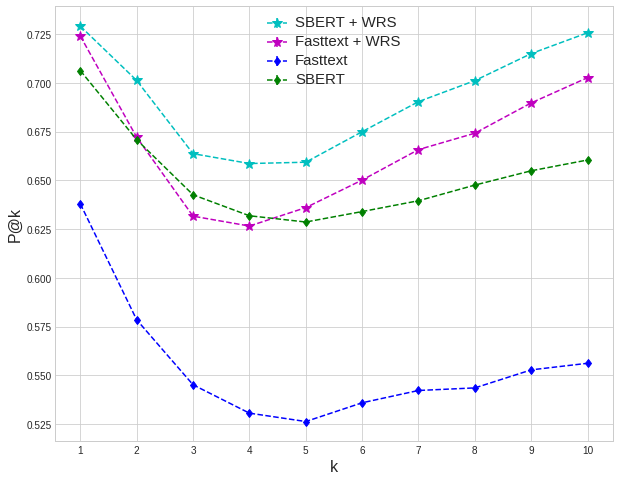

In [342]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure

fig = plt.figure(figsize=(10,8))
#model val
a = all_pk_p_ft
#non-model val
b = all_pk_p_tr

c = all_pk_m_ft

d = all_pk_m_tr

plt.errorbar(x, d , yerr=yerr, uplims=False, lolims=False,
             label='SBERT + WRS', c='c', marker="*",ms=11, ls = "--")


plt.errorbar(x, c , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext + WRS', c='m', marker="*",ms=11, ls = "--")

x=list(range(1,MAX_K))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, a , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext', c='b', marker="d", ls = "--")

plt.errorbar(x, b , yerr=yerr, uplims=False, marker= "d",c="g",ls = "--",lolims=False,
             label="SBERT")
ax = plt.gca()
#ax.set_xlim([xmin, xmax])

plt.xlabel('k', fontsize=16)
plt.ylabel('P@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'Pk'+VERSION+'.png',dpi=300)
plt.show()

## tablice

In [263]:
ks=[1,2,3,4,5,6,7,8,9,10,50,100]

In [264]:
all_pk_m_ft,all_pk_m_ft=[],[]

for k in ks:
    users_res=[]
    for ur in user_ranks_m_ft:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)])) 


    #print("P@k; k=",k)
    #print("model-mean for all users:", np.mean(users_res) )
    all_pk_m_ft.append(np.mean(users_res))

    users_res=[]
    for ur in user_ranks_p_ft:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)]))
    #print("non-model-mean for all users:", np.mean(users_res) )
    all_pk_p_ft.append(np.mean(users_res)) 
    
    

In [265]:
all_pk_m_diff = [i - j for i, j in zip(all_pk_m_ft, all_pk_p_ft)]

In [266]:
a=pd.DataFrame(data=zip(ks,all_pk_p_ft,all_pk_m_ft, all_pk_m_diff),columns=['k','Fasttext P@k *','Fasttext + WRS P@k *', "delta *"])

In [267]:
all_pk_m_tr,all_pk_m_tr=[],[]

for k in ks:
    users_res=[]
    for ur in user_ranks_m_tr:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)])) 


    #print("P@k; k=",k)
    #print("model-mean for all users:", np.mean(users_res) )
    all_pk_m_tr.append(np.mean(users_res))

    users_res=[]
    for ur in user_ranks_p_tr:
        num_relevant=len([r for r in ur if r < k])
        users_res.append(num_relevant/np.min([k,len(ur)]))
    #print("non-model-mean for all users:", np.mean(users_res) )
    all_pk_p_tr.append(np.mean(users_res)) 
    
    

In [268]:
all_pk_m_diff = [i - j for i, j in zip(all_pk_m_tr, all_pk_p_tr)]

In [269]:
b=pd.DataFrame(data=zip(ks,all_pk_p_tr,all_pk_m_tr, all_pk_m_diff),columns=['k','SBERT P@k **','SBERT + WRS P@k **', "delta **"])

In [270]:
all_pk_m_diff = [i - j for i, j in zip(all_pk_m_ft, all_pk_p_tr)]

In [272]:
c=pd.DataFrame(data=zip(ks,all_pk_p_tr,all_pk_m_ft, all_pk_m_diff),columns=['k','SBERT P@k ***','Fasttext + WRS P@k ***', "delta ***"])

In [274]:
d=pd.merge(a, b, left_on='k', right_on='k')

In [276]:
e=pd.merge(d, c, left_on='k', right_on='k')

In [279]:
e=e.T

In [314]:
e

,0,1,2,3,4,5,6,7,8,9,10,11
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,50.000000,100.000000
Fasttext P@k *,0.637975,0.578481,0.545148,0.530591,0.526287,0.535907,0.542218,0.543541,0.552794,0.556176,0.686761,0.774583
Fasttext + WRS P@k *,0.724051,0.672152,0.631646,0.626582,0.636034,0.650169,0.665799,0.674210,0.689761,0.702709,0.859541,0.919117
delta *,0.086076,0.093671,0.086498,0.095992,0.109747,0.114262,0.123580,0.130669,0.136967,0.146533,0.172780,0.144533
SBERT P@k **,0.706329,0.670886,0.642616,0.631857,0.628650,0.634008,0.639566,0.647592,0.654931,0.660471,0.706329,0.670886
SBERT + WRS P@k **,0.729114,0.701266,0.663713,0.658650,0.659325,0.674979,0.690410,0.701193,0.715065,0.725727,0.888212,0.934501
delta **,0.022785,0.030380,0.021097,0.026793,0.030675,0.040970,0.050844,0.053602,0.060135,0.065256,0.181883,0.263615
SBERT P@k ***,0.706329,0.670886,0.642616,0.631857,0.628650,0.634008,0.639566,0.647592,0.654931,0.660471,0.706329,0.670886
Fasttext + WRS P@k ***,0.724051,0.672152,0.631646,0.626582,0.636034,0.650169,0.665799,0.674210,0.689761,0.702709,0.859541,0.919117
delta ***,0.017722,0.001266,-0.010970,-0.005274,0.007384,0.016160,0.026233,0.026618,0.034830,0.042238,0.153212,0.248231


In [280]:
e.to_excel(SAVE_PATH+"patk1.xlsx") 

## modificirani nDCG Fasttext

In [332]:
all_ndcg_m_ft=[]
for ur in user_ranks_m_ft:
    dcg=np.sum([1/np.log2(r+2) for r in ur]) #1 relevant 0 otherwise
    idcg= np.sum([1/np.log2(r+2) for r in range(len(ur))])  #ideal dcg, ranks start at 0 -> +1
    ndcg=dcg/idcg
    users_res.append(ndcg)

#print("\nnDCG:")
#print("model-mean for all users:", np.mean(users_res) )

all_ndcg_p_ft=[]
for ur in user_ranks_p_ft:
    dcg=np.sum([1/np.log2(r+2) for r in ur]) #1 relevant 0 otherwise
    idcg= np.sum([1/np.log2(r+2) for r in range(0,len(ur))])  #ideal dcg
    ndcg=dcg/idcg
    users_res.append(ndcg)

#print("non-model-mean for all users:", np.mean(users_res) )

In [333]:
print(len(set(ids_lab_df['userID'])))

395


In [334]:
K_MAX=11

users_res_m_ft=dict()
for k in range(1, K_MAX):
    users_res_m_ft[k]=list() 

for k in range(1,K_MAX):
    for ur in user_ranks_m_ft:
        M=np.min([k,len(ur)])
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_m_ft[k].append(ndcg)
                         
#mean for each k
for k,v in users_res_m_ft.items():
    users_res_m_ft[k]=np.mean(v)

In [335]:
users_res_p_ft=dict()

for k in range(1, K_MAX):
    users_res_p_ft[k]=list() 

for k in range(1,K_MAX):#1..10
    for ur in user_ranks_p_ft:
        M=np.min([k,len(ur)]) 
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_p_ft[k].append(ndcg)

#mean for each k
for k,v in users_res_p_ft.items():
    users_res_p_ft[k]=np.mean(v)

In [231]:
print(">>>>>>>>>>>> delta rank 1= ",users_res_m_ft[1]-users_res_p_ft[1])

>>>>>>>>>>>> delta rank 1=  0.08607594936708862


In [232]:
VERSION = "_fw1_"

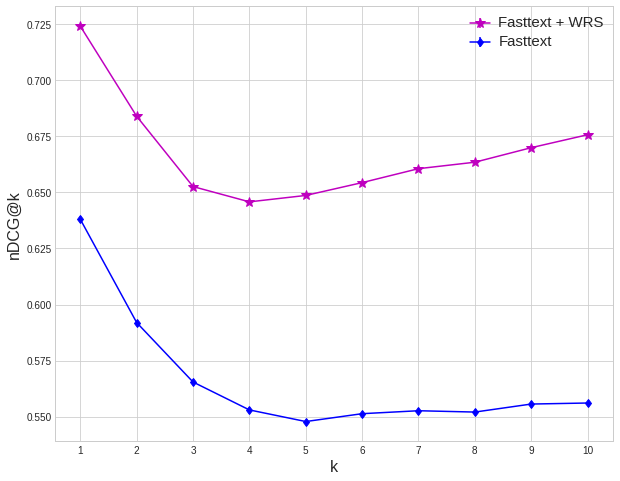

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure



fig = plt.figure(figsize=(10,8))
#model val
y_m = [v for k,v in users_res_m_ft.items()]
#non-model val
y_p = [v for k,v in users_res_p_ft.items()]

x=list(range(1,K_MAX))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext + WRS', c='m', marker="*",ms=11)

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",lolims=False,
             label="Fasttext",c='b')

plt.xlabel('k', fontsize=16)
plt.ylabel('nDCG@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'ndcg'+VERSION+'.png')
plt.show()


## SBERT 

In [234]:
VERSION = "_sw1_"

In [325]:
all_ndcg_m_tr=[]
for ur in user_ranks_m_tr:
    dcg=np.sum([1/np.log2(r+2) for r in ur]) #1 relevant 0 otherwise
    idcg= np.sum([1/np.log2(r+2) for r in range(len(ur))])  #ideal dcg, ranks start at 0 -> +1
    ndcg=dcg/idcg
    users_res.append(ndcg)

#print("\nnDCG:")
#print("model-mean for all users:", np.mean(users_res) )

all_ndcg_p_tr=[]
for ur in user_ranks_p_tr:
    dcg=np.sum([1/np.log2(r+2) for r in ur]) #1 relevant 0 otherwise
    idcg= np.sum([1/np.log2(r+2) for r in range(0,len(ur))])  #ideal dcg
    ndcg=dcg/idcg
    users_res.append(ndcg)

#print("non-model-mean for all users:", np.mean(users_res) )

In [236]:
print(len(set(ids_lab_df['userID'])))

395


In [326]:
K_MAX=11

users_res_m_tr=dict()
for k in range(1, K_MAX):
    users_res_m_tr[k]=list() 

for k in range(1,K_MAX): #za svaki k
    for ur in user_ranks_m_tr:  #za svakog korisnika
        M=np.min([k,len(ur)])
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_m_tr[k].append(ndcg) #dodaj ndcg
                         
#mean for each k
for k,v in users_res_m_tr.items():
    users_res_m_tr[k]=np.mean(v)

In [327]:
users_res_p_tr=dict()

for k in range(1, K_MAX):
    users_res_p_tr[k]=list() 

for k in range(1,K_MAX):#1..10
    for ur in user_ranks_p_tr:
        M=np.min([k,len(ur)]) 
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_p_tr[k].append(ndcg)

#mean for each k
for k,v in users_res_p_tr.items():
    users_res_p_tr[k]=np.mean(v)

In [239]:
print(">>>>>>>>>>>> delta rank 1= ",users_res_m_tr[1]-users_res_p_tr[1])

>>>>>>>>>>>> delta rank 1=  0.02278481012658229


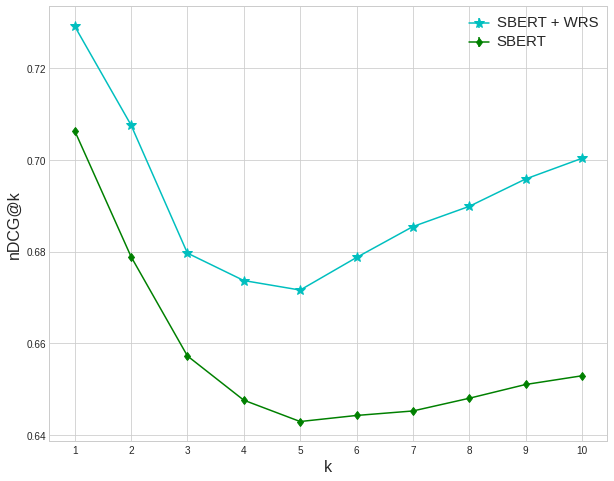

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure



fig = plt.figure(figsize=(10,8))
#model val
y_m = [v for k,v in users_res_m_tr.items()]
#non-model val
y_p = [v for k,v in users_res_p_tr.items()]

x=list(range(1,K_MAX))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='SBERT + WRS', c='c', marker="*",ms=11)

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",lolims=False,
             label="SBERT",c='g')

plt.xlabel('k', fontsize=16)
plt.ylabel('nDCG@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'ndcg'+VERSION+'.png')
plt.show()


In [242]:
VERSION = "_fw_s1_"

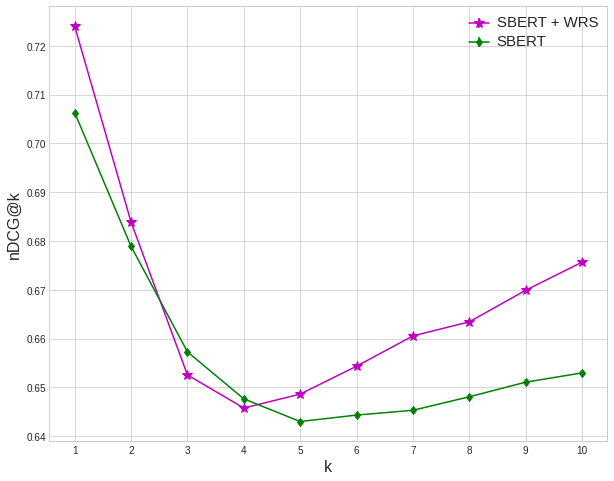

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure



fig = plt.figure(figsize=(10,8))
#model val
y_m = [v for k,v in users_res_m_ft.items()]
#non-model val
y_p = [v for k,v in users_res_p_tr.items()]

x=list(range(1,K_MAX))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='SBERT + WRS', c='m', marker="*",ms=11)

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",lolims=False,
             label="SBERT",c='g')

plt.xlabel('k', fontsize=16)
plt.ylabel('nDCG@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'ndcg'+VERSION+'.png')
plt.show()


## 

In [244]:
VERSION = "_fs1_"

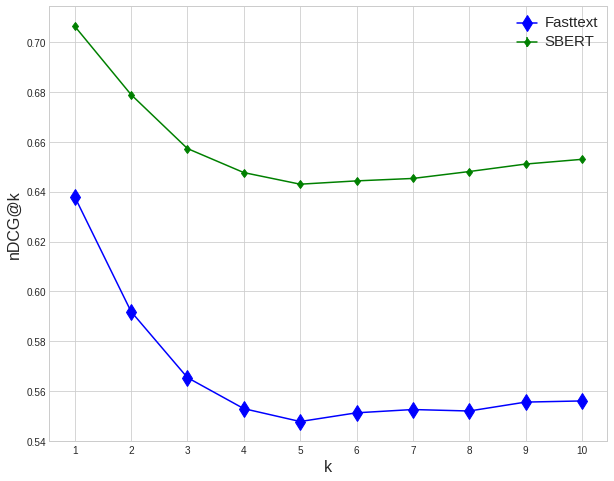

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure



fig = plt.figure(figsize=(10,8))
#model val
y_m = [v for k,v in users_res_p_ft.items()]
#non-model val
y_p = [v for k,v in users_res_p_tr.items()]

x=list(range(1,K_MAX))

yerr = np.linspace(0.0, 0.0, len(x)) #any value will do

plt.errorbar(x, y_m , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext', c='b', marker="d",ms=11)

plt.errorbar(x, y_p , yerr=yerr, uplims=False, marker= "d",lolims=False,
             label="SBERT",c='g')

plt.xlabel('k', fontsize=16)
plt.ylabel('nDCG@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'ndcg'+VERSION+'.png')
plt.show()


In [336]:
VERSION="_all_"

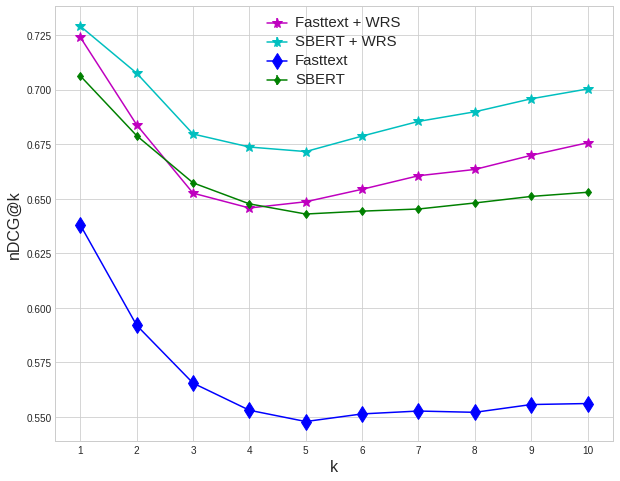

In [337]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from matplotlib.pyplot import figure

x=list(range(1,K_MAX))
yerr = np.linspace(0.0, 0.0, len(x)) #any value will do


fig = plt.figure(figsize=(10,8))
#model val
a = [v for k,v in users_res_p_ft.items()]
#non-model val
b = [v for k,v in users_res_p_tr.items()]

c = [v for k,v in users_res_m_tr.items()]


d = [v for k,v in users_res_m_ft.items()]

plt.errorbar(x, d , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext + WRS', c='m', marker="*",ms=11)

plt.errorbar(x, c , yerr=yerr, uplims=False, lolims=False,
           label='SBERT + WRS', c='c', marker="*",ms=11)


plt.errorbar(x, a , yerr=yerr, uplims=False, lolims=False,
             label='Fasttext', c='b', marker="d",ms=11)

plt.errorbar(x, b , yerr=yerr, uplims=False, marker= "d",lolims=False,
             label="SBERT",c='g')

plt.xlabel('k', fontsize=16)
plt.ylabel('nDCG@k', fontsize=16)
plt.legend(loc='best')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='15') #legend 'list' fontsize

ax =fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(SAVE_PATH + 'ndcg'+VERSION+'.png')
plt.show()


## tablice

In [294]:

users_res_m_tr=dict()
for k in ks:
    users_res_m_tr[k]=list() 
    
users_res_p_tr=dict()

for k in ks:
    users_res_p_tr[k]=list() 


for k in ks:
    for ur in user_ranks_m_tr:  #za svakog korisnika
        M=np.min([k,len(ur)])
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_m_tr[k].append(ndcg) #dodaj ndcg
    for ur in user_ranks_p_tr:
        M=np.min([k,len(ur)]) 
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_p_tr[k].append(ndcg)
                         
#mean for each k
for k,v in users_res_m_tr.items():
    users_res_m_tr[k]=np.mean(v)
#mean for each k
for k,v in users_res_p_tr.items():
    users_res_p_tr[k]=np.mean(v)

In [301]:

users_res_m_ft=dict()
for k in ks:
    users_res_m_ft[k]=list() 
    
users_res_p_ft=dict()

for k in ks:
    users_res_p_ft[k]=list() 


for k in ks:
    for ur in user_ranks_m_ft:  #za svakog korisnika
        M=np.min([k,len(ur)])
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_m_ft[k].append(ndcg) #dodaj ndcg
    for ur in user_ranks_p_ft:
        M=np.min([k,len(ur)]) 
        dcg=np.sum([1/np.log2(r+2) for r in ur if r < k]) #1 relevant 0 otherwise 
        idcg= np.sum([1/np.log2(r+2) for r in range(M)])  #ideal dcg, ranks start at 0 -> +1
        ndcg=dcg/idcg
        users_res_p_ft[k].append(ndcg)
                         
#mean for each k
for k,v in users_res_m_ft.items():
    users_res_m_ft[k]=np.mean(v)
#mean for each k
for k,v in users_res_p_ft.items():
    users_res_p_ft[k]=np.mean(v)

In [302]:
ndcg_m_ft=users_res_m_ft.values()
ndcg_p_ft=users_res_p_ft.values()

ndcg_m_tr=users_res_m_tr.values()
ndcg_p_tr=users_res_p_tr.values()

In [300]:
ndcg_m_ft

dict_values([0.7291139240506329, 0.7075676917489623, 0.6796744947695167, 0.6737029082079314, 0.6716284058669058, 0.6787255067520251, 0.6854571889857395, 0.6898647086510961, 0.6958263087761449, 0.7003280609412582, 0.7599698492787438, 0.7767738462865719])

In [304]:
all_ndcg_m_diff = [i - j for i, j in zip(ndcg_m_ft, ndcg_p_ft)]

In [309]:
a=pd.DataFrame(data=zip(ks,ndcg_p_ft,ndcg_m_ft, all_ndcg_m_diff),columns=['k','ndcg@k Fasttext *','Fasttext + WRS ndcg *', "delta *"])

In [310]:
a

,k,ndcg@k Fasttext *,Fasttext + WRS ndcg *,delta *
0,1,0.637975,0.724051,0.086076
1,2,0.591944,0.683896,0.091952
2,3,0.565456,0.652560,0.087105
3,4,0.553014,0.645755,0.092741
4,5,0.547842,0.648613,0.100771
5,6,0.551338,0.654329,0.102991
6,7,0.552654,0.660544,0.107890
7,8,0.552063,0.663423,0.111360
8,9,0.555634,0.669896,0.114262
9,10,0.556097,0.675664,0.119567


In [311]:
all_ndcg_m_diff = [i - j for i, j in zip(ndcg_m_tr, ndcg_p_tr)]

In [312]:
b=pd.DataFrame(data=zip(ks,ndcg_p_tr, ndcg_m_tr, all_ndcg_m_diff),columns=['k','ndcg@k SBERT **','SBERT + WRS ndcg **', "delta **"])

In [313]:
b

,k,ndcg@k SBERT **,SBERT + WRS ndcg **,delta **
0,1,0.706329,0.729114,0.022785
1,2,0.678907,0.707568,0.028661
2,3,0.657279,0.679674,0.022396
3,4,0.647641,0.673703,0.026062
4,5,0.642989,0.671628,0.028639
5,6,0.644312,0.678726,0.034413
6,7,0.645290,0.685457,0.040167
7,8,0.648060,0.689865,0.041805
8,9,0.651058,0.695826,0.044768
9,10,0.652955,0.700328,0.047373


In [315]:
all_ndcg_m_diff = [i - j for i, j in zip(ndcg_m_ft, ndcg_p_tr)]

In [316]:
c=pd.DataFrame(data=zip(ks,ndcg_p_tr, ndcg_m_ft, all_ndcg_m_diff),columns=['k','ndcg@k SBERT ***','Fasttext + WRS ndcg ***', "delta ***"])

In [317]:
d=pd.merge(a, b, left_on='k', right_on='k')

In [318]:
e=pd.merge(d, c, left_on='k', right_on='k')

In [319]:
e=e.T

In [314]:
e

,0,1,2,3,4,5,6,7,8,9,10,11
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,50.000000,100.000000
Fasttext P@k *,0.637975,0.578481,0.545148,0.530591,0.526287,0.535907,0.542218,0.543541,0.552794,0.556176,0.686761,0.774583
Fasttext + WRS P@k *,0.724051,0.672152,0.631646,0.626582,0.636034,0.650169,0.665799,0.674210,0.689761,0.702709,0.859541,0.919117
delta *,0.086076,0.093671,0.086498,0.095992,0.109747,0.114262,0.123580,0.130669,0.136967,0.146533,0.172780,0.144533
SBERT P@k **,0.706329,0.670886,0.642616,0.631857,0.628650,0.634008,0.639566,0.647592,0.654931,0.660471,0.706329,0.670886
SBERT + WRS P@k **,0.729114,0.701266,0.663713,0.658650,0.659325,0.674979,0.690410,0.701193,0.715065,0.725727,0.888212,0.934501
delta **,0.022785,0.030380,0.021097,0.026793,0.030675,0.040970,0.050844,0.053602,0.060135,0.065256,0.181883,0.263615
SBERT P@k ***,0.706329,0.670886,0.642616,0.631857,0.628650,0.634008,0.639566,0.647592,0.654931,0.660471,0.706329,0.670886
Fasttext + WRS P@k ***,0.724051,0.672152,0.631646,0.626582,0.636034,0.650169,0.665799,0.674210,0.689761,0.702709,0.859541,0.919117
delta ***,0.017722,0.001266,-0.010970,-0.005274,0.007384,0.016160,0.026233,0.026618,0.034830,0.042238,0.153212,0.248231


In [321]:
e.to_excel(SAVE_PATH+"ndcg1.xlsx") 